You just acquired land in the mountains that has a set of huts and trails cut through it. You had the land surveyed and got the results in a SQL database. 

Let's set up the land as a ski hill!

## Initial Setup

In [1]:
import ski_hill_database_utils
import utils
DB_PATH = "ski_hill.db"

Run once: Populate database with synthetic data

In [2]:
ski_hill_database_utils.create_ski_hill_db(DB_PATH, n_huts=20)

SQLite database 'ski_hill.db' created with a 'mountain_huts' table and 'trails' table.


In [3]:
schema_text = ski_hill_database_utils.get_schema(DB_PATH)
utils.print_html(schema_text, f"Table Schemas in {DB_PATH}")

Get a sense of the data by showing the first 5 entries in each table

In [4]:
query_all_mountain_huts = "select * from mountain_huts order by altitude desc limit 5;"
all_mountain_huts = ski_hill_database_utils.execute_sql(
    query=query_all_mountain_huts,
    db_path=DB_PATH)
utils.print_html(all_mountain_huts, query_all_mountain_huts)
query_all_trails = "select * from trails limit 5;"
all_trails = ski_hill_database_utils.execute_sql(
    query=query_all_trails,
    db_path=DB_PATH)
utils.print_html(all_trails, query_all_trails)

id,name,altitude
10,Tibult Tibult,14138
6,YNot Chalet,13809
1,Septuagint Goodall,13518
17,Tibult Henrik,13157
14,Quartile Vail,12617


hut1,hut2
1,3
17,2
10,3
7,4
4,5


Visualize the mountain huts and trails

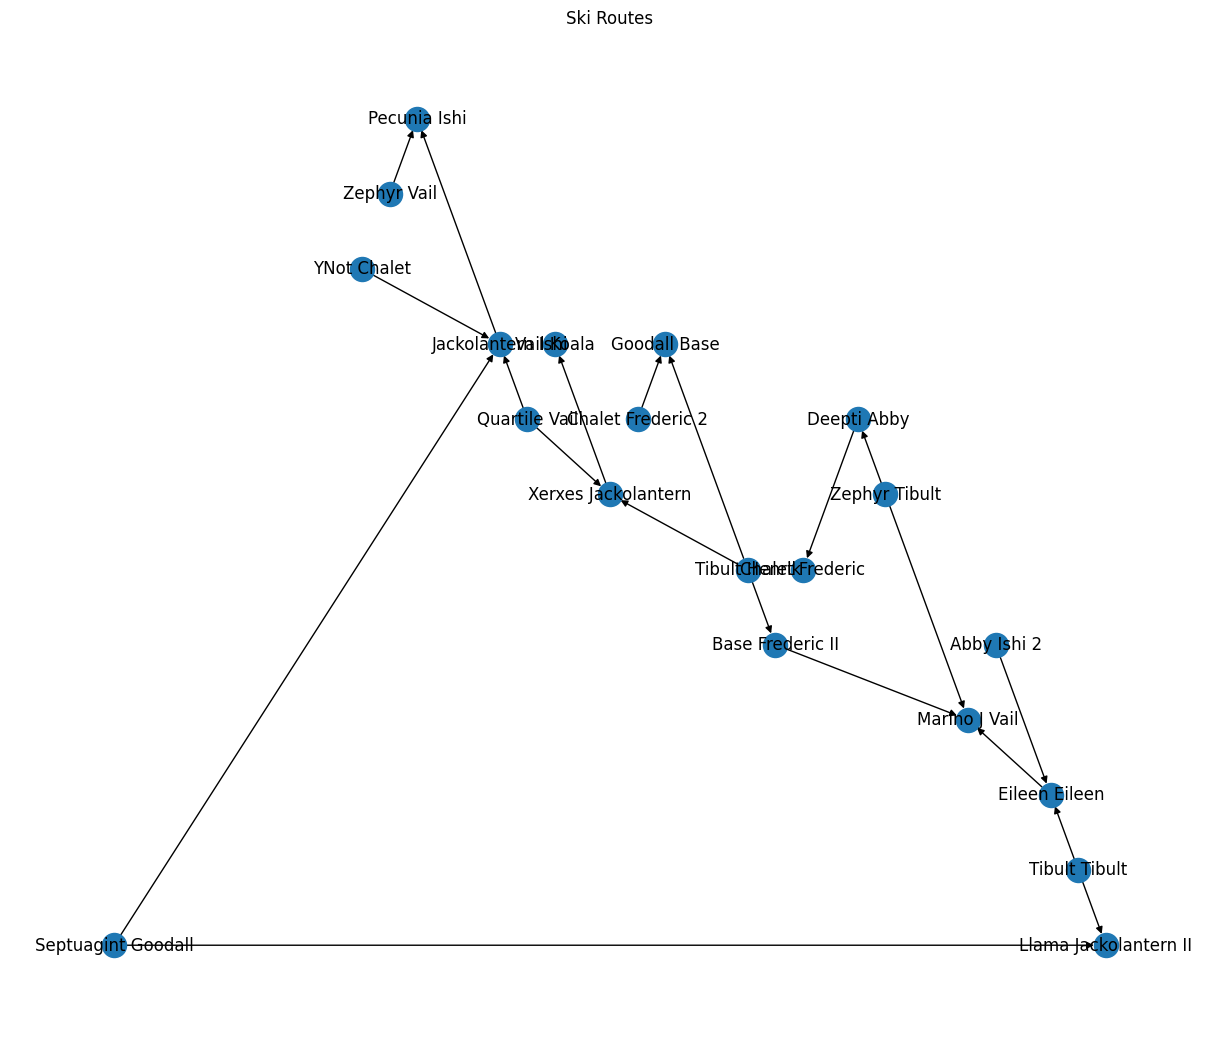

In [2]:
ski_hill_database_utils.graph_ski_routes(DB_PATH)

## Learning Opportunities

### Propose Ski Hill Routes

Write SQL query to propose new ski routes, based on the existing `mountain_huts` and `trails`.

Start by joining the `trails` to itself to establish the hierarchy of the trails (highest hut -> middle hut -> lowest hut)

In [22]:
query = """
    select first_segment.hut1 as proposed_start,
        first_segment.hut2 as proposed_middle,
        second_segment.hut2 as proposed_end
    from trails first_segment
    join trails second_segment
        on first_segment.hut2 = second_segment.hut1
    """
results = ski_hill_database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Trail Segments")

proposed_start,proposed_middle,proposed_end
7,4,5
6,16,14
6,16,20
9,7,4
9,7,12
17,9,7
12,10,3
7,12,10
13,12,10
16,14,19


Now we join the information from `mountain_huts` to fill in the names of the huts

In [27]:
query = """
    select starting_hut.name as proposed_start,
        starting_hut.altitude as starting_altitude,
        middle_hut.name as proposed_middle,
        middle_hut.altitude as middle_altitude,
        ending_hut.name as proposed_end,
        ending_hut.altitude as ending_altitude
    from trails first_segment
    join trails second_segment
        on first_segment.hut2 = second_segment.hut1
    join mountain_huts starting_hut
        on starting_hut.id = first_segment.hut1
    join mountain_huts middle_hut
        on middle_hut.id = first_segment.hut2
    join mountain_huts ending_hut
        on ending_hut.id = second_segment.hut2
    """
results = ski_hill_database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Trail Segments")

proposed_start,starting_altitude,proposed_middle,middle_altitude,proposed_end,ending_altitude
Marino J Vail,4657,Zephyr Tibult,12502,Deepti Abby,10699
YNot Chalet,13809,Jackolantern Ishi,6255,Quartile Vail,12617
YNot Chalet,13809,Jackolantern Ishi,6255,Pecunia Ishi,5075
Base Frederic II,5821,Marino J Vail,4657,Zephyr Tibult,12502
Base Frederic II,5821,Marino J Vail,4657,Eileen Eileen,6725
Tibult Henrik,13157,Base Frederic II,5821,Marino J Vail,4657
Eileen Eileen,6725,Tibult Tibult,14138,Llama Jackolantern II,10373
Marino J Vail,4657,Eileen Eileen,6725,Tibult Tibult,14138
Abby Ishi 2,10840,Eileen Eileen,6725,Tibult Tibult,14138
Jackolantern Ishi,6255,Quartile Vail,12617,Xerxes Jackolantern,10323


But this resulting set isn't necessarily a set of routes with a decreasing slope

In [ ]:
query = """
    select starting.name as startpt, middle.name as midpt, ending.name as endpt
    from trails first_segment
    join trails second_segment on first_segment.hut2 = second_segment.hut1
    join mountain_huts starting on starting.id = first_segment.hut1
    join mountain_huts middle on middle.id = first_segment.hut2
    join mountain_huts ending on ending.id = second_segment.hut2
    where starting.altitude > middle.altitude and middle.altitude > ending.altitude
    """
results = ski_hill_database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Trail Segments")

startpt,midpt,endpt
YNot Chalet,Jackolantern Ishi,Pecunia Ishi
Tibult Henrik,Base Frederic II,Marino J Vail
Septuagint Goodall,Jackolantern Ishi,Pecunia Ishi
Quartile Vail,Xerxes Jackolantern,Vail Koala


Note: the entries in `trails` are bi-directional and the order of `hut1`, `hut2` doesn't mean that the altitude of hut1 is greater than that of hut2.

So we need a reformulation of the `trails` table such that we capture both possibilities of `hut1` -> `hut2` and `hut2` -> `hut1`. Using a WITH statement, we can establish a UNION of `trails` with itself and carry that forward.

In [ ]:
query = """
    with bd_trails as (
        select hut1, hut2 from trails
        union
        select hut2 as hut1, hut1 as hut2 from trails
    )
    select starting.name as startpt,
        middle.name as middlept,
        ending.name as endpt
    from bd_trails first_segment
    join bd_trails second_segment
        on first_segment.hut2 = second_segment.hut1
    join mountain_huts starting on starting.id = first_segment.hut1
    join mountain_huts middle on middle.id = first_segment.hut2
    join mountain_huts ending on ending.id = second_segment.hut2
    where starting.altitude > middle.altitude and middle.altitude > ending.altitude
    """
results = ski_hill_database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Proposed Routes")

startpt,middlept,endpt
Zephyr Tibult,Deepti Abby,Chalet Frederic
Tibult Henrik,Base Frederic II,Marino J Vail
Tibult Tibult,Eileen Eileen,Marino J Vail
Abby Ishi 2,Eileen Eileen,Marino J Vail
Septuagint Goodall,Jackolantern Ishi,Pecunia Ishi
YNot Chalet,Jackolantern Ishi,Pecunia Ishi
Quartile Vail,Jackolantern Ishi,Pecunia Ishi
Quartile Vail,Xerxes Jackolantern,Vail Koala
Tibult Henrik,Xerxes Jackolantern,Vail Koala


Add summary information for the altitude change

In [ ]:
query = """
    with bd_trails as (
        select hut1, hut2 from trails
        union
        select hut2 as hut1, hut1 as hut2 from trails
    )
    select starting.name as startpt,
        middle.name as middlept,
        ending.name as endpt,
        (starting.altitude - ending.altitude) as altdiff
    from bd_trails first_segment
    join bd_trails second_segment on first_segment.hut2 = second_segment.hut1
    join mountain_huts starting on starting.id = first_segment.hut1
    join mountain_huts middle on middle.id = first_segment.hut2
    join mountain_huts ending on ending.id = second_segment.hut2
    where starting.altitude > middle.altitude and middle.altitude > ending.altitude
    order by altdiff desc
    """
results = ski_hill_database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Proposed Routes and Altitude Change")

startpt,middlept,endpt,altdiff
Tibult Tibult,Eileen Eileen,Marino J Vail,9481
YNot Chalet,Jackolantern Ishi,Pecunia Ishi,8734
Tibult Henrik,Base Frederic II,Marino J Vail,8500
Septuagint Goodall,Jackolantern Ishi,Pecunia Ishi,8443
Tibult Henrik,Xerxes Jackolantern,Vail Koala,8056
Quartile Vail,Jackolantern Ishi,Pecunia Ishi,7542
Quartile Vail,Xerxes Jackolantern,Vail Koala,7516
Zephyr Tibult,Deepti Abby,Chalet Frederic,7451
Abby Ishi 2,Eileen Eileen,Marino J Vail,6183


### Longer Slopes

Are any longer runs possible? And is there a better way to generalize building routes?

In [42]:
query = """
    select first_segment.hut1 as proposed_start,
        first_segment.hut2 as proposed_middle1,
        second_segment.hut2 as proposed_middle2,
        third_segment.hut2 as proposed_end
    from trails first_segment
    join trails second_segment
        on first_segment.hut2 = second_segment.hut1
    join trails third_segment
        on second_segment.hut2 = third_segment.hut1
    """
results = ski_hill_database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Trail Segments")

proposed_start,proposed_middle1,proposed_middle2,proposed_end
6,16,14,19
9,7,4,5
9,7,12,10
17,9,7,4
17,9,7,12
7,12,10,3
13,12,10,3
16,14,19,15
16,14,19,17
1,16,14,19


In [46]:
query = """
    with bd_trails as (
        select hut1, hut2 from trails
        union
        select hut2 as hut1, hut1 as hut2 from trails
    )
    select starting.name as startpt,
        second_hut.name as secondpt,
        third_hut.name as thirdpt,
        ending.name as endpt,
        (starting.altitude - ending.altitude) as altdiff
    from bd_trails first_segment
    join bd_trails second_segment on first_segment.hut2 = second_segment.hut1
    join bd_trails third_segment on second_segment.hut2 = third_segment.hut1
    join mountain_huts starting on starting.id = first_segment.hut1
    join mountain_huts second_hut on second_hut.id = first_segment.hut2
    join mountain_huts third_hut on third_hut.id = second_segment.hut2
    join mountain_huts ending on ending.id = third_segment.hut2
    where starting.altitude > second_hut.altitude 
        and second_hut.altitude > third_hut.altitude
        and third_hut.altitude > ending.altitude
    order by altdiff desc
    """
results = ski_hill_database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Proposed Routes with 4 huts and Altitude Change")

startpt,secondpt,thirdpt,endpt,altdiff


Looks like there's no eligible routes for this generated set. That's likely because there's so few huts. With only 20 huts generated in the database, a three segment ski run is pretty unlikely. 

I suppose there could be catways or lifts that could connect huts to create other combinations, but that's not present in the available data at this time.

### Orphaned Huts
Notice that not all `mountain_huts` are in use. Can you find which huts are left off the list? We may want to close those down, or find some other use for them.

In [47]:
# Find huts that are missing from `trails` (might not be any)
abandoned_huts_query="""
    select mountain_huts.* from mountain_huts
    join (
        select id from mountain_huts
        except select hut1 from trails
        except select hut2 from trails
    ) as m2
    on mountain_huts.id = m2.id
    """
results = ski_hill_database_utils.execute_sql(
    query=abandoned_huts_query,
    db_path=DB_PATH)
utils.print_html(results, "Abandoned Mountain Huts")

id,name,altitude


As you can see above, all mountain huts are connected to at least one other hut. We could consider adjusting the generated ski hill data to create this scenario, but we'll proceed under the current conditions.

The brutish way to look at the invalid ski routes would be to adjust the final `WHERE` comparison

In [49]:
abandoned_huts_query="""
    with bd_trails as (
        select hut1, hut2 from trails
        union
        select hut2 as hut1, hut1 as hut2 from trails
    )
    select starting.name as startpt,
        middle.name as middlept,
        ending.name as endpt,
        (starting.altitude - ending.altitude) as altdiff
    from bd_trails first_segment
    join bd_trails second_segment on first_segment.hut2 = second_segment.hut1
    join mountain_huts starting on starting.id = first_segment.hut1
    join mountain_huts middle on middle.id = first_segment.hut2
    join mountain_huts ending on ending.id = second_segment.hut2
    where starting.altitude > ending.altitude
        and (starting.altitude < middle.altitude
        or middle.altitude < ending.altitude)
    order by altdiff desc
    """
results = ski_hill_database_utils.execute_sql(
    query=abandoned_huts_query,
    db_path=DB_PATH)
utils.print_html(results, "Invalid Ski Slopes")

startpt,middlept,endpt,altdiff
Zephyr Tibult,Marino J Vail,Base Frederic II,6681
Deepti Abby,Zephyr Tibult,Marino J Vail,6042
Zephyr Tibult,Marino J Vail,Eileen Eileen,5777
Xerxes Jackolantern,Tibult Henrik,Base Frederic II,4502
Llama Jackolantern II,Septuagint Goodall,Jackolantern Ishi,4118
Xerxes Jackolantern,Quartile Vail,Jackolantern Ishi,4068
Goodall Base,Tibult Henrik,Base Frederic II,3821
Llama Jackolantern II,Tibult Tibult,Eileen Eileen,3648
Tibult Tibult,Eileen Eileen,Abby Ishi 2,3298
Tibult Henrik,Goodall Base,Chalet Frederic 2,2087


## Maintenance Opportunities

What if some of the `mountain_huts` are in a state of disrepair?

In [ ]:
# TODO
# update the database with a new column for hut quality,
#   based on "survey" done by experts (just randomly generate it, lol)
update_query = """
    UPDATE mountain_huts
    """

What about the quality of the existing routes? Are they a bunny slope, cat track, green, blue, black, double black, backcountry?

In [ ]:
# TODO

## Operating Analysis

What about current conditions? Are the routes powder (fresh, untracked snow), moguls(bumps on a ski run), gnarly (extreme conditions)

Let's incorporate a table of weather data

In [ ]:
# TODO